/home/hessel/miniconda3/envs/thesis/lib/python3.12/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
/tmp/ipykernel_6536/1482268276.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_6536/1482268276.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


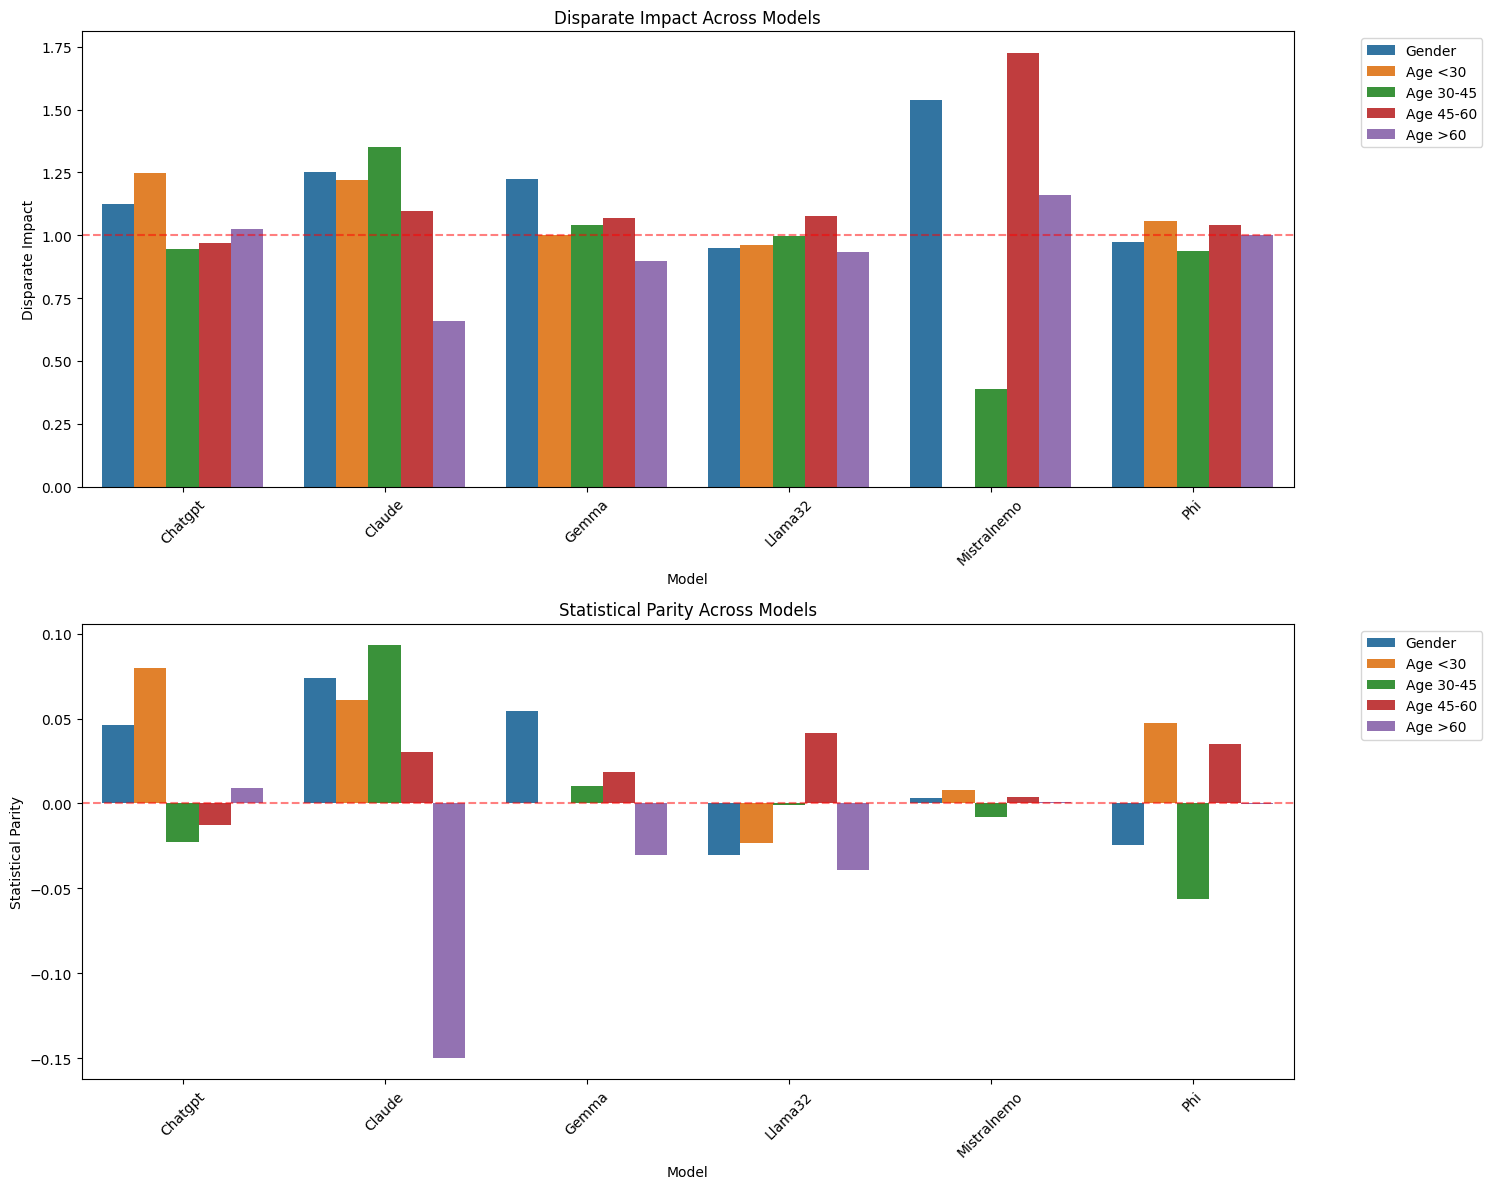


Summary Statistics:
          Disparate Impact           Statistical Parity          
                      mean       std               mean       std
Type                                                             
Age 30-45         0.943443  0.312696           0.002689  0.050220
Age 45-60         1.163050  0.279159           0.019359  0.020672
Age <30                inf       NaN           0.028793  0.039839
Age >60           0.945840  0.166335          -0.034892  0.059575
Gender            1.176386  0.216402           0.020472  0.043775


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
import re

def extract_demographics(prompt):
    if not isinstance(prompt, str):
        return None, None, None
    
    age_match = re.search(r'(\d+)-year-old', prompt)
    gender_match = re.search(r'-year-old\s+(\w+)', prompt)
    
    age = int(age_match.group(1)) if age_match else None
    gender = gender_match.group(1).lower() if gender_match else None
    
    gender_binary = 1.0 if gender == 'male' else 0.0 if gender == 'female' else None
    age_value = pd.cut([age], bins=[0, 30, 45, 60, float('inf')], labels=['<30', '30-45', '45-60', '>60'])[0] if age else None
    
    age_groups = {f'age_group_{i}': 1.0 if age_value == label else 0.0 
                 for i, label in enumerate(['<30', '30-45', '45-60', '>60'])}
    
    return gender_binary, age_value, age_groups

def extract_fraud_label(response):
    if pd.isna(response):
        return np.nan
    try:
        return 1.0 if 'fraud' in response.lower() else 0.0
    except:
        return np.nan

def analyze_bias(df, protected_attr):
    try:
        dataset = BinaryLabelDataset(
            df=df,
            label_names=['label'],
            protected_attribute_names=[protected_attr],
            privileged_protected_attributes=[[1.0]]
        )
        
        metrics = BinaryLabelDatasetMetric(
            dataset,
            unprivileged_groups=[{protected_attr: 0.0}],
            privileged_groups=[{protected_attr: 1.0}]
        )
        
        return {
            'disparate_impact': metrics.disparate_impact(),
            'statistical_parity': metrics.statistical_parity_difference()
        }
    except:
        return {'disparate_impact': np.nan, 'statistical_parity': np.nan}

def analyze_models(df):
    model_columns = ['chatgpt_response', 'claude_response', 'gemma_response', 
                     'llama32_response', 'mistralnemo_response', 
                    'phi_response']
    
    all_results = {}
    
    # Extract demographics
    demographics = df['Prompt'].apply(extract_demographics)
    df['gender_binary'] = demographics.apply(lambda x: x[0])
    df['age_group'] = demographics.apply(lambda x: x[1])
    
    for i, grp in enumerate(['<30', '30-45', '45-60', '>60']):
        df[f'age_group_{i}'] = demographics.apply(lambda x: x[2][f'age_group_{i}'])
    
    # Analyze each model
    for model_col in model_columns:
        model_name = model_col.split('_')[0].capitalize()
        df['label'] = df[model_col].apply(extract_fraud_label)
        
        model_results = {}
        
        # Gender analysis
        df_gender = df[['label', 'gender_binary']].dropna()
        if len(df_gender) > 0:
            model_results['gender'] = analyze_bias(df_gender, 'gender_binary')
        
        # Age group analysis
        for i in range(4):
            df_age = df[['label', f'age_group_{i}']].dropna()
            if len(df_age) > 0:
                model_results[f'age_group_{i}'] = analyze_bias(df_age, f'age_group_{i}')
        
        all_results[model_name] = model_results
    
    return all_results

def plot_bias_metrics(results):
    metrics_df = []
    for model, model_results in results.items():
        for attr_type, values in model_results.items():
            metrics_df.append({
                'Model': model,
                'Type': 'Gender' if attr_type == 'gender' else f'Age {["<30", "30-45", "45-60", ">60"][int(attr_type.split("_")[-1])]}',
                'Disparate Impact': values['disparate_impact'],
                'Statistical Parity': values['statistical_parity']
            })
    
    metrics_df = pd.DataFrame(metrics_df)
    
    # Create subplots for both metrics
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # Disparate Impact plot
    sns.barplot(data=metrics_df, x='Model', y='Disparate Impact', hue='Type', ax=axes[0])
    axes[0].axhline(y=1, color='r', linestyle='--', alpha=0.5)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_title('Disparate Impact Across Models')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Statistical Parity plot
    sns.barplot(data=metrics_df, x='Model', y='Statistical Parity', hue='Type', ax=axes[1])
    axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    axes[1].set_title('Statistical Parity Across Models')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return metrics_df

# Load and analyze data
df = pd.read_csv('../../results/combined_model_responses.ssv', sep=";")
results = analyze_models(df)

# Display numerical results and create plots
metrics_df = plot_bias_metrics(results)

# Print summary statistics
print("\nSummary Statistics:")
print(metrics_df.groupby('Type')[['Disparate Impact', 'Statistical Parity']].agg(['mean', 'std']))